In [1]:
!pip install vaderSentiment

In [2]:
import textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
plt.rcParams['figure.figsize'] = [20, 8]

In [3]:
plt.rcParams['figure.figsize'] = [20, 8]

# Read tweets csv
df = pd.read_csv("../../data/Tweets3Weeks.csv")

# Drop all-null rows if any
df.dropna(how='all', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,8,18,23,24,26,27,29,31,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Vader sentiment
vader = SentimentIntensityAnalyzer()

In [5]:
def clean_df(df):
    """
    Input: A df of tweets
    Returns: A df that cleans the input 
             df and returns it.
    """
    rows_to_drop = []
    for i in range(len(df)):
        curr_row = df.iloc[i]
        if (pd.isna(curr_row['full_text'])) or pd.isna(curr_row['created_at']) or not str(curr_row['created_at']).endswith("2019"):
            rows_to_drop.append(i)
    print ("Dropping", len(rows_to_drop), "rows!")
    if len(rows_to_drop) == 0:
        return df
    return df.drop(rows_to_drop)
        
def add_sentiment_to_df(df):
    # Sentiment values
    neg, pos, neu, compound = [], [], [], []
    
    # Failed entries for debugging laters
    failed = []
    for i, text in enumerate(df['full_text']):
        try:
            sentiment_dict = vader.polarity_scores(text)
            neg.append(sentiment_dict['neg'])
            neu.append(sentiment_dict['neu'])
            pos.append(sentiment_dict['pos'])
            compound.append(sentiment_dict['compound'])     
        except:
            failed.append(i)
    assert(len(failed) == 0)
    df['neg'] = neg
    df['neu'] = neu
    df['pos'] = pos
    df['compound'] = compound
    return df

In [6]:
df = clean_df(df)
df = add_sentiment_to_df(df)

Dropping 2 rows!


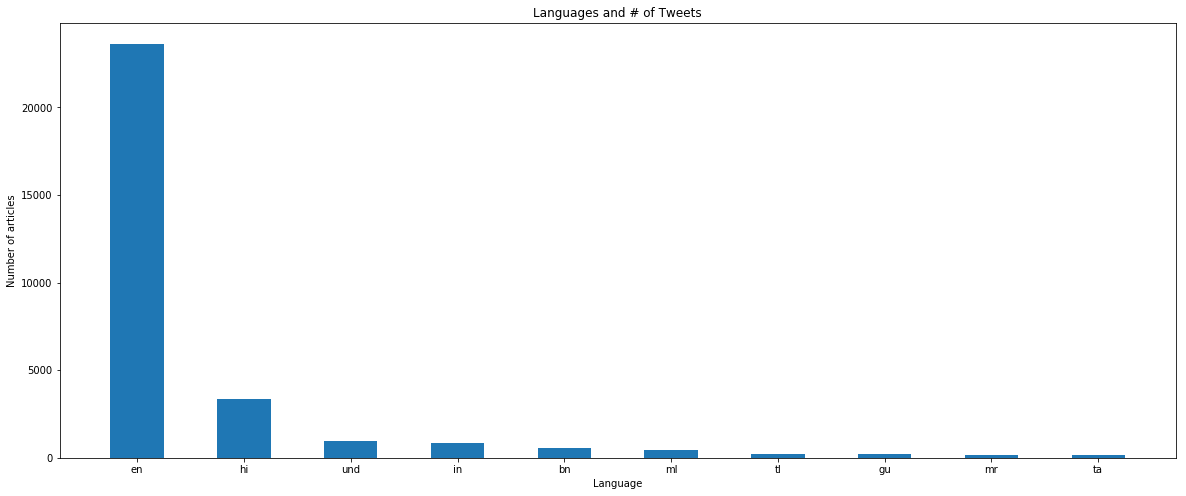

In [7]:
lang_count = Counter(df['lang'])
del lang_count['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>']
lang_count = sorted(lang_count.items(), key=lambda x: -x[1])

counter = np.array(lang_count)[:10]
places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Language")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices, places)
plt.title("Languages and # of Tweets")
_ = plt.bar(indices, counts, 0.5)

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])
# Sort by time created
df.sort_values(by=['created_at'], inplace=True)

In [9]:
def tweets_by_day(df):
    """
    Input: A df with created_at column
           converted by pd.to_datetime
    Returns: A dict with date as key and
             tweets on that date as values
    """
    min_date = min(df['created_at']).date()
    max_date = max(df['created_at']).date()
    
    date_dict = {}
    
    assert(max_date > min_date)
    
    date_range = pd.date_range(min_date, max_date)
    
    dates = [x.date() for x in df['created_at']]
    
    df['date'] = dates
    
    for date in dates:
        date_dict[str(date)] = df[df['date'] == date]
    del df['date']
    return date_dict

In [10]:
date_dict = tweets_by_day(df)

In [11]:
num_tweets = np.array([[x, int(len(date_dict[x]))] for x in date_dict])
print(num_tweets)

[['2019-02-23' '172']
 ['2019-02-24' '642']
 ['2019-02-25' '752']
 ['2019-02-26' '704']
 ['2019-02-27' '464']
 ['2019-02-28' '1629']
 ['2019-03-01' '990']
 ['2019-03-02' '1552']
 ['2019-03-03' '2065']
 ['2019-03-04' '2189']
 ['2019-03-05' '1338']
 ['2019-03-06' '1339']
 ['2019-03-07' '1293']
 ['2019-03-08' '954']
 ['2019-03-09' '1019']
 ['2019-03-10' '1522']
 ['2019-03-11' '1967']
 ['2019-03-12' '1403']
 ['2019-03-13' '1491']
 ['2019-03-14' '1278']
 ['2019-03-15' '998']
 ['2019-03-16' '935']
 ['2019-03-17' '1401']
 ['2019-03-18' '1324']
 ['2019-03-19' '1592']]


### Current Features
   * Number of tweets each day
   * Average pos, neg, neu and compound features
   * Tweet count with neg sentiment

### TODO
   * Hate speech
   * Violent speech

In [17]:
def get_features(date_dict):
    """
    Input: date_dict to compute features for each date
    Returns: Features for each date
    """
    features = []
    for date in date_dict:
        feature_row = []
        tweets = date_dict[date]
        
        feature_row.append(len(tweets))
        mean = tweets.mean()
        
        feature_row.extend([mean['pos'], mean['neg'], mean['neu'], mean['compound']])
        feature_row.append(len(tweets[tweets['neg'] > 0]))
        
        features.append(feature_row)
    return features

In [19]:
features = get_features(date_dict)

In [20]:
np.save("features.npy", features)